C:\Users\Hp\anaconda3\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
C:\Users\Hp\anaconda3\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
C:\Users\Hp\anaconda3\Lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('fut

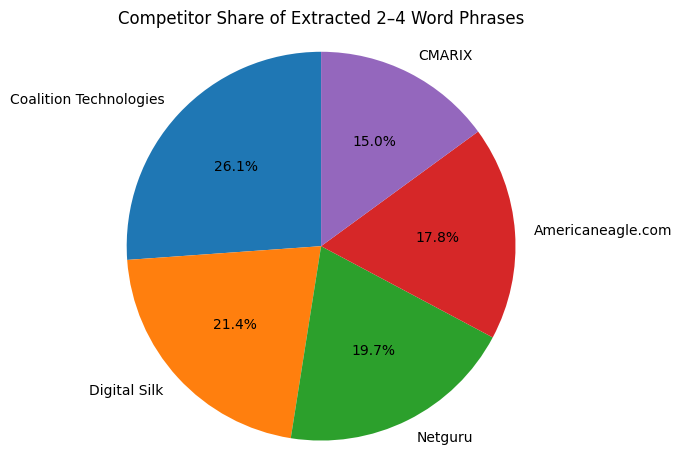


Data saved as 'competitor_keywords_with_metrics.csv' and 'competitor_keywords_with_metrics.xlsx'


In [4]:
import re
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
import random

# ---------------------------
# STEP 1 — Competitor seed data
# ---------------------------
competitors = {
    "Coalition Technologies": {
        "url": "https://coalitiontechnologies.com/custom-web-development",
        "text": (
            "Custom Web Development. We create beautiful, user-friendly websites and apps. "
            "Our web development team uses the latest software and technology to create custom apps "
            "and cutting-edge websites that keep your business at the forefront of your industry."
        )
    },
    "Netguru": {
        "url": "https://www.netguru.com/services/web-development",
        "text": (
            "Web Development Services. We design and build industry-leading web-based products that delight customers. "
            "Achieve your business goals with web development solutions. Websites that build trust and generate leads."
        )
    },
    "Digital Silk": {
        "url": "https://www.digitalsilk.com/web-development/custom-web-development/",
        "text": (
            "Custom Web Development Company. Build a high-performance website that drives results. "
            "Custom UX and UI design, search and conversion optimization, end-to-end development. "
            "Create engaging corporate sites and complex animations."
        )
    },
    "Americaneagle.com": {
        "url": "https://www.americaneagle.com/",
        "text": (
            "Creating digital experiences that drive growth. Web and application development, experience design, "
            "digital marketing, strategy and insights, hosting and managed cloud services, client services, "
            "artificial intelligence consulting."
        )
    },
    "CMARIX": {
        "url": "https://www.cmarix.com/web-development.html",
        "text": (
            "Web Development Company. Fully custom websites built for results. "
            "User experience, scalability, security. Backend development, frontend development, "
            "JavaScript development, CMS development, eCommerce development."
        )
    }
}

# ---------------------------
# STEP 2 — Helper functions
# ---------------------------

# Only punctuation marks in stopwords list
stopwords = [',', '.', '!', '(', ')', '[', ']', '{', '}', '"', "'"]

def normalize(text):
    # Lowercase & remove punctuation from stopwords list
    for p in stopwords:
        text = text.replace(p, " ")
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s\-&]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokens(text):
    toks = re.split(r"[\s\-&]+", text)
    toks = [t for t in toks if t]  # remove empty strings
    return toks

def ngrams(toks, n):
    return [" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)]

# ---------------------------
# STEP 3 — Extract keyword phrases
# ---------------------------
records = []
for name, info in competitors.items():
    url = info["url"]
    text = normalize(info["text"])
    toks = tokens(text)

    for n in [2, 3, 4]:
        counts = Counter(ngrams(toks, n))
        for phrase, freq in counts.items():
            wc = len(phrase.split())
            if wc == 2:
                tail = "Short tail (2)"
            elif wc == 3:
                tail = "Mid tail (3)"
            else:
                tail = "Long tail (4)"
            records.append({
                "keyword": phrase,
                "source_url": url,
                "competitor": name,
                "frequency": freq,
                "tail_type": tail
            })

df = pd.DataFrame(records).drop_duplicates(subset=["keyword", "competitor"])

# ---------------------------
# STEP 4 — Keyword Volume via PyTrends
# ---------------------------
pytrends = TrendReq(hl='en-US', tz=360)

volumes = {}
for kw in df["keyword"].unique():
    try:
        pytrends.build_payload([kw], cat=0, timeframe='today 12-m', geo='', gprop='')
        data = pytrends.interest_over_time()
        if not data.empty:
            volumes[kw] = int(data[kw].mean())  # average popularity index
        else:
            volumes[kw] = 0
    except:
        volumes[kw] = 0

df["volume_index"] = df["keyword"].map(volumes)

# ---------------------------
# STEP 5 — Mock Difficulty & CPC
# ---------------------------
max_vol = max(df["volume_index"].max(), 1)
df["difficulty"] = (100 - (df["volume_index"] / max_vol * 100)).round(2)
df["cpc_usd"] = [round(random.uniform(0.5, 15), 2) for _ in range(len(df))]

# ---------------------------
# STEP 6 — Visualization
# ---------------------------
share = df.groupby("competitor")["keyword"].nunique().sort_values(ascending=False)

plt.figure()
plt.pie(share.values, labels=share.index, autopct='%1.1f%%', startangle=90)
plt.title("Competitor Share of Extracted 2–4 Word Phrases")
plt.axis('equal')
plt.tight_layout()
plt.show()

# ---------------------------
# STEP 7 — Save
# ---------------------------
df.to_csv("competitor_keywords_with_metrics.csv", index=False)
df.to_excel("competitor_keywords_with_metrics.xlsx", index=False)

print("\nData saved as 'competitor_keywords_with_metrics.csv' and 'competitor_keywords_with_metrics.xlsx'")
